In [1]:
import os
import sys
import git
import pathlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [3]:
from lib.folder_paths import makeget_logging_dir, get_exp_name_tag, deconstruct_exp_name

In [4]:
# Get name of experiments (agents)
env_id = "BreakoutNoFrameskip-v4"
exp_param_type = "compress"
exp_param_value_LIST = [0.0, 0.1, 0.2, 0.3, 0.4]

model_type_LIST = ["best", "last"]
color_LIST = ["red", "blue"]
color_dict = dict(zip(model_type_LIST, color_LIST))

exp_name_LIST = []
for exp_param_value in exp_param_value_LIST:
    # Get names and tags of experiment
    exp_name, exp_metaname, exp_tag = get_exp_name_tag(env_id, exp_param_type, exp_param_value)
    exp_name_LIST.append(exp_name)

NUM_OF_AGENTS = len(exp_name_LIST)

In [5]:
# Evaluation environment parameters
eval_param_value_LIST = [0.0, 0.1, 0.2, 0.3, 0.4]
NUM_OF_EVAL_ENV = len(eval_param_value_LIST)

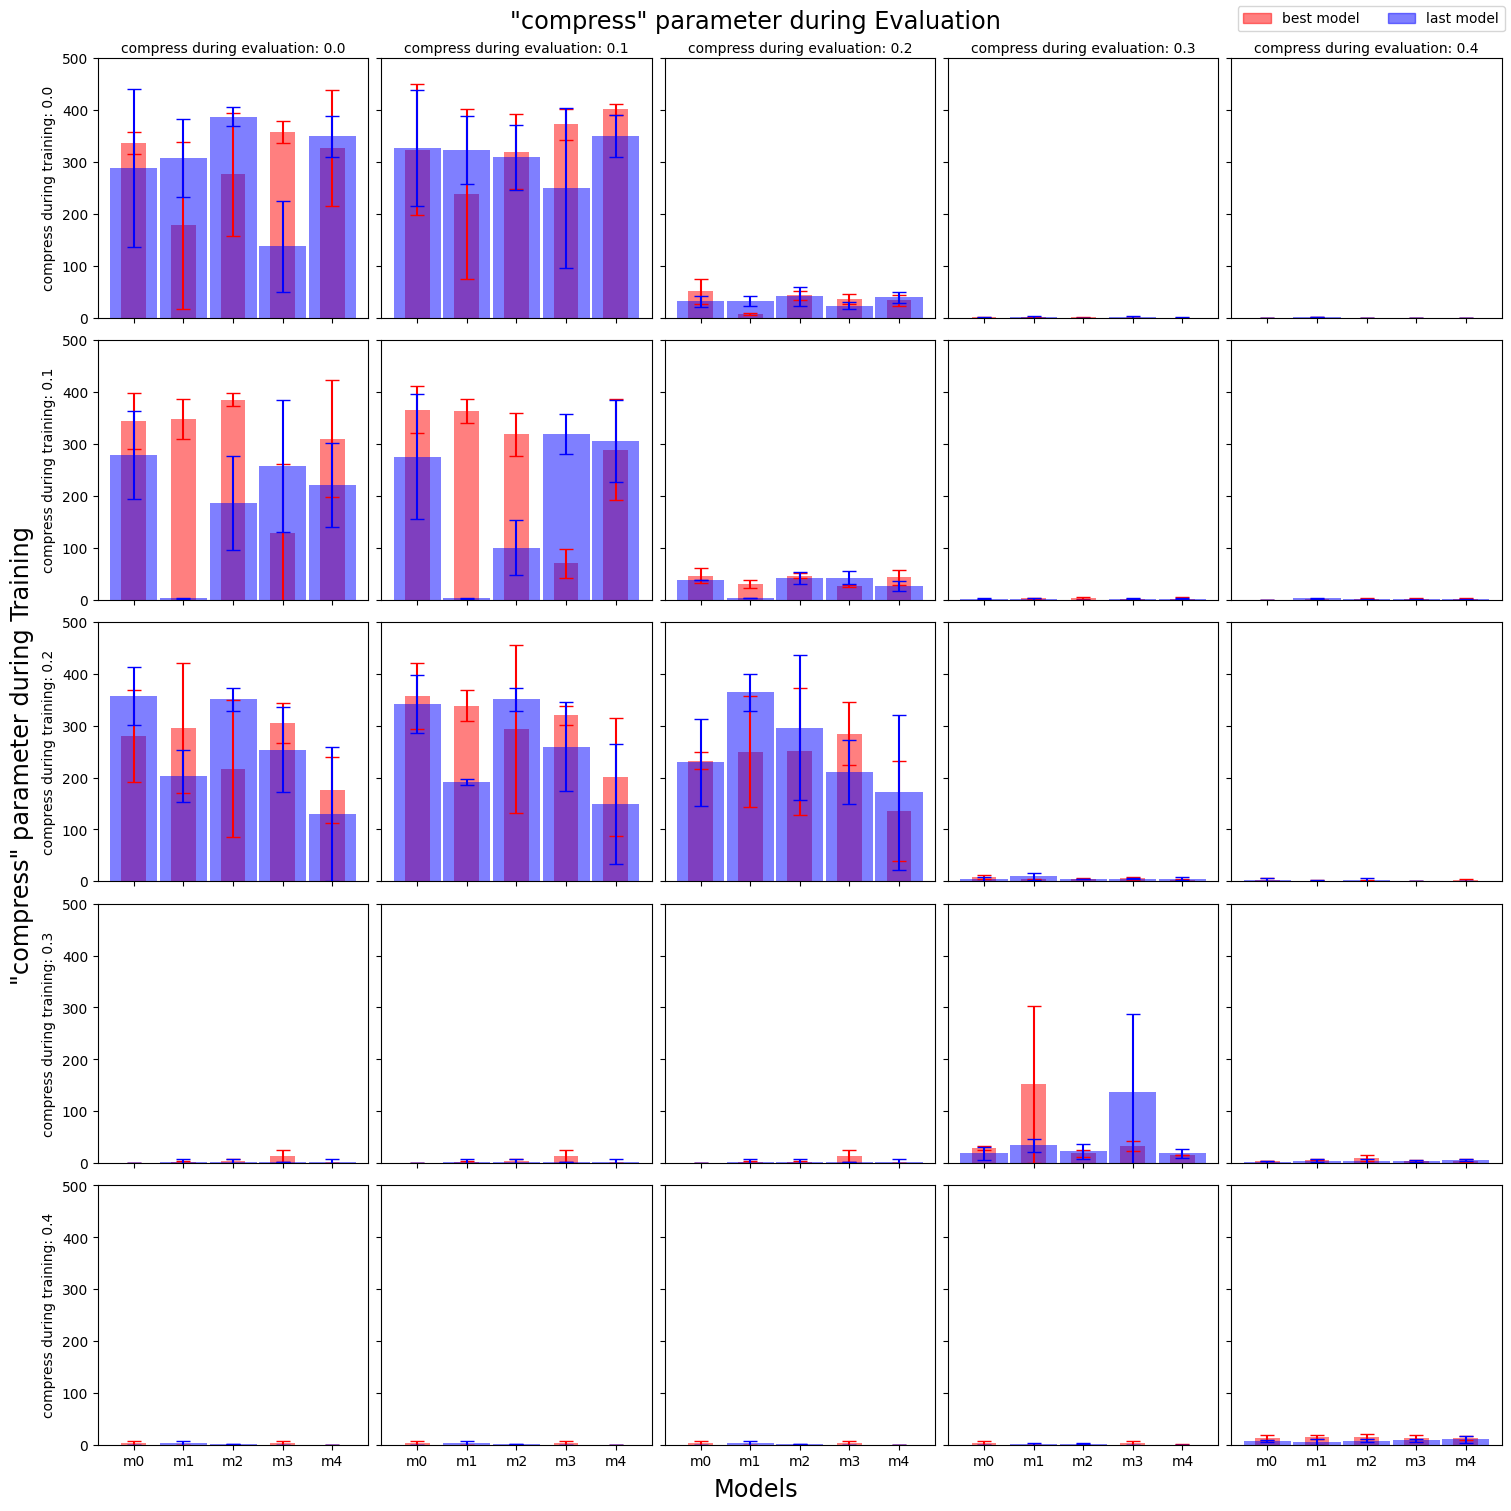

In [7]:
fig_width = 15
fig_height = 15
fig, axes = plt.subplots(nrows=NUM_OF_AGENTS, 
                         ncols=NUM_OF_EVAL_ENV,
                         figsize=[fig_width,fig_height],
                         layout='constrained',
                         sharex=True,
                         sharey=True)

for row, exp_name in enumerate(exp_name_LIST):
    env_id, exp_param_type, exp_param_value, exp_metaname = deconstruct_exp_name(exp_name)
    eval_param_type = exp_param_type
    for col, eval_param_value in enumerate(eval_param_value_LIST):
        ax = axes[row][col]
        ax.set_ylim((0,500))

        # Here avoiding printing the labels for inner axis plots.
        # Print the feature labels only on the left side of the pair-plot figure
              
        if col == 0 and row!= 0:
            ylabel = f"{exp_param_type} during training: {exp_param_value}"
            xlabel = ""

        # Print the feature labels only on the top side of the pair-plot figure. 
        if row == 0 and col != 0:
            ylabel=""
            xlabel = f"{exp_param_type} during evaluation: {eval_param_value}"

        if col == 0 and row == 0:
            ylabel = f"{exp_param_type} during training: {exp_param_value}"
            xlabel = f"{exp_param_type} during evaluation: {eval_param_value}"

        if col !=0 and row !=0:
            xlabel = ""
            ylabel = ""

        ax.set(xlabel=xlabel,ylabel=ylabel)
        ax.xaxis.set_label_position('top')
        
        for model_type in model_type_LIST:
            # Get directories
            models_dir, log_dir, gif_dir, image_dir = makeget_logging_dir(exp_name)
    
            # Get csv filename
            csv_filename = f"{exp_name}--eval_{model_type}-{eval_param_type}_{eval_param_value}.csv"
            csv_file = pathlib.Path(log_dir / csv_filename)
    
            # Read csv
            df = pd.read_csv(csv_file, sep='\t', encoding='utf-8')
    
            # Get global_avg, global_std
            global_avg = np.mean(df["avg"])
            global_std = np.std(df["avg"])
    
            # Set plot params
            if model_type == "best":
                barwidth=0.5
            else:
                barwidth=0.95
                
            # Plot
            ax.bar(x=[f"m{x}" for x in df.index], 
                   height=df["avg"], 
                   yerr=df["std"],
                   capsize=5,
                   ecolor=color_dict[model_type],
                  alpha=0.5,
                  width=barwidth,
                  color=color_dict[model_type])
            
fig.supxlabel('Models', fontsize='xx-large');
fig.suptitle(f'"{exp_param_type}" parameter during Evaluation', fontsize='xx-large');
fig.supylabel(f'"{exp_param_type}" parameter during Training', fontsize='xx-large');


legend_elements = [ Patch(facecolor=color_dict[model_type], edgecolor=color_dict[model_type], label=f"{model_type} model", alpha=0.5) for model_type in model_type_LIST]
fig.legend(handles=legend_elements,  loc='upper right', ncols=2)



logdir_root = pathlib.Path(PROJ_ROOT_PATH / "logging")
filename = f"{env_id}--{exp_tag.split('_')[0]}--all_eval_summary-barplot.png"
file = pathlib.Path(logdir_root / filename)
fig.savefig(file)